In [1]:
import pandas as pd
import os
from datetime import date
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support

def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month

#Read dataset
df = pd.read_csv('filtered_dataset/others.csv')
df2 = pd.read_csv('processed_dataset/bio_portered_CV.csv')
df = df.drop(['class'],axis=1)
               
#Create new column for age of account in months at time of tweet
df.insert(0, 'user_account_age_months', [diff_month(date1,date2) for date1, date2 in zip(pd.to_datetime(df['created_at'], infer_datetime_format=True), pd.to_datetime(df['user created at'], infer_datetime_format=True))])

#Convert boolean columns to integers
df['user is verified'] = [int(x == True) for x in df['user is verified']]
df['user has url'] = [int(x == True) for x in df['user has url']]

#drop unneeded columns
df = df.drop(['created_at'], axis=1)
df = df.drop(['user created at'], axis=1)

#write processed dataset to .csv
os.makedirs('processed_dataset', exist_ok=True)
df.to_csv('processed_dataset/others.csv',index=False) 

In [2]:
df3 = pd.concat([df,df2], axis=1, join='inner')
df = df3

In [3]:
def split_data_train_test_split(X,y):
 from sklearn.model_selection import train_test_split
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
 return(X_train, X_test,y_train,y_test)

In [4]:
from sklearn.decomposition import PCA
def perform_PCA (X_train, y_train, total_components, n_components):
  pca = PCA(n_components=total_components, random_state=0)
  pca.fit(X_train)
  X_pca = pca.transform(X_train)

  print("Variance explained by all", total_components, "principal components =", sum(pca.explained_variance_ratio_ * 100))

  csum = np.cumsum(pca.explained_variance_ratio_ * 100)
  print(csum)
  print ()

  # plot 
  import matplotlib.pyplot as plt
  plt.plot(csum)
  plt.xlabel('Number of components')
  plt.ylabel('Explained variance')
  #plt.savefig('elbow_plot.png', dpi=100)

  # find the number of components
  print (csum[n_components-1])

  x_train_pca=[x[:n_components] for x in X_pca]

  print (len(x_train_pca[0]))
  print ()

  return x_train_pca

In [5]:
def normalize(df):
    for feature in df.columns:
        feature_min = df[feature].min()
        feature_max = df[feature].max()
        df[feature] = (df[feature] - feature_min) / (feature_max - feature_min)    
    return df

In [6]:
#PCA on data
y = df['class']
X = df.copy()
X.drop ('class', axis=1, inplace=True)
X = normalize(X)

Variance explained by all 1511 principal components = 100.00000000000001
[  6.99529653   9.51222987  11.19752543 ... 100.         100.
 100.        ]

95.9032627761354
1000



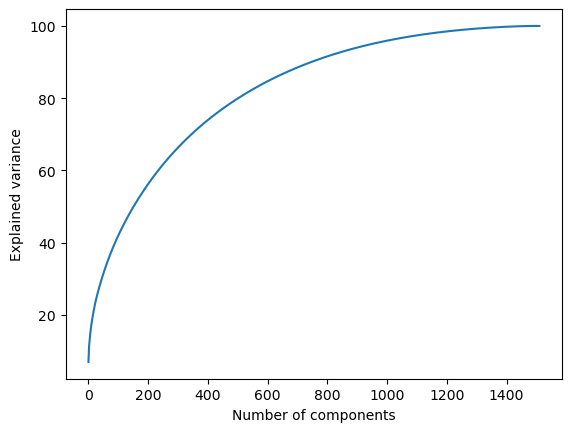

In [7]:
# PCA
X_pca = perform_PCA(X, y, len(X.columns), 1000)

In [8]:
X_train, X_test,y_train,y_test=split_data_train_test_split(X_pca,y)

In [9]:
class Data:
    def __init__(self, x_train, y_train, x_test, y_test):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

class Result:
    def __init__(self, y_test, y_pred, label=None):
        self.label = label
        self.accuracy = accuracy_score(y_test,y_pred) * 100
        self.precision = precision_score(y_test, y_pred, average='binary')
        self.recall = recall_score(y_test, y_pred, average='binary')
        self.f1 = f1_score(y_test, y_pred, average='binary')
        self.confusion_matrix = confusion_matrix(y_test, y_pred)
        
    def show(self):
        print("Accuracy = ",self.accuracy,"%")
        print("Precision = ",self.precision)
        print("Recall = ",self.recall)
        print("F1 Score = ",self.f1)
        print("Confusion Matrix: \n", self.confusion_matrix)
        
def getResult(data, res):
    result = Result(data.y_test, res)
    result.show()
    return result

from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import make_scorer

def getBestModel(data, model, param_grid, cv=10):
    scorer = make_scorer(metrics.recall_score, average='binary')
    grid = GridSearchCV(model, 
                        param_grid,
                        cv=cv,
                        scoring=scorer)

    grid.fit(data.x_train, data.y_train)
    
    return grid

In [10]:
data = Data(X_train, y_train, X_test, y_test)

In [11]:

random_forest_params_grid = {
#    'n_estimators': [i for i in range(100, 1000, 10)],
    'n_estimators': [100],
    'criterion': ['gini', 'entropy'],
    'criterion': ['entropy'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'random_state': [0]
}

grid = getBestModel(data, RandomForestClassifier(), random_forest_params_grid,cv=2)

y_pred = grid.predict(data.x_test)
getResult(data, y_pred)
grid.best_params_

Accuracy =  82.12435233160622 %
Precision =  0.5671641791044776
Recall =  0.17592592592592593
F1 Score =  0.26855123674911663
Confusion Matrix: 
 [[913  29]
 [178  38]]


{'criterion': 'entropy',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100,
 'random_state': 0}

In [12]:
#SVM
from sklearn.svm import SVC
from sklearn import svm

svm_param_grid = {'C': [0.1, 0.2, 0.3, 0.5, 1, 2, 3, 5, 10], 
                  'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
                  'gamma': [1,0.1,0.01,0.001]
                 } 
svm_param_grid = {'C': [0.1, 0.2, 0.3, 0.5, 1, 2, 3, 5, 10], 
                  'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
                  'gamma': [1,0.1,0.01,0.001]
                 } 

svm_param_grid = {'C': [0.1, 0.2, 0.3, 0.5, 1, 2, 3, 5, 10], 
                  'kernel': ['linear']
#                  'gamma': [1,0.1,0.01,0.001]
                  }

#grid = getBestModel(data, svm.SVC(), svm_param_grid, cv=2)

#y_pred = grid.predict(data.x_test)
#getResult(data, y_pred)
#grid.best_params_